# Confidence intervals and A/B testing

Ryan Reece     
2018-02-26

Contents:

1.  [Introduction](#introduction)
1.  [Generate some toy data](#generate_some_toy_data)
1.  [$z$ statistic](#z_statistic)
1.  [Normal approximation to the binomial](#normal_approximation_to_the_binomial)
1.  [$t$ statistic](#t_statistic)
1.  [$\chi^2$ statistic](#chi2_statistic)
1.  [See also](#see_also)

<a id="introduction"></a>

## Introduction

When testing for discrepancy/consistency, we want to note when a $p$-value is especially small, or equivalently, that a confidence level is exceeded.  The absolute threshold for notability is somewhat arbitrary and dependent on domain and our tolerances for false-positives and negatives.  Typically, one will note when a statistic is outside of 

| Confidence Level |  z$-value |
|-----------------:|----------:|
|              80% |      1.28 |
|              85% |      1.44 |
|              90% |      1.64 |
|              95% |      1.96 |
|              98% |      2.33 |
|              99% |      2.58 |

| Confidence interval [$\sigma$]  |  Fraction inside [%] |  Fraction outside [%] |      Fraction outside |
|-------------------------------:|---------------------:|----------------------:|----------------------:|
|                       0.674490 |                   50 |                    50 |                 1 / 2 | 
|                       0.994458 |                   68 |                    32 |             1 / 3.125 |
|                              1 |           68.2689492 |            31.7310508 |         1 / 3.1514872 |
|                       1.281552 |                   80 |                    20 |                 1 / 5 | 
|                       1.644854 |                   90 |                    10 |                1 / 10 |
|                       1.959964 |                   95 |                     5 |                1 / 20 |
|                              2 |           95.4499736 |             4.5500264 |         1 / 21.977895 |
|                       2.575829 |                   99 |                     1 |               1 / 100 |
|                              3 |           99.7300204 |             0.2699796 |           1 / 370.398 |
|                       3.290527 |                 99.9 |                   0.1 |              1 / 1000 |
|                       3.890592 |                99.99 |                  0.01 |             1 / 10000 |
|                              4 |            99.993666 |              0.006334 |             1 / 15787 |
|                       4.417173 |               99.999 |                 0.001 |            1 / 100000 |
|                            4.5 |     99.9993204653751 |       0.0006795346249 |         3.4 / 1000000 |
|                       4.891638 |              99.9999 |                0.0001 |           1 / 1000000 |
|                              5 |        99.9999426697 |          0.0000573303 |           1 / 1744278 |
|                       5.326724 |             99.99999 |               0.00001 |          1 / 10000000 |
|                       5.730729 |            99.999999 |              0.000001 |         1 / 100000000 |
|                              6 |        99.9999998027 |          0.0000001973 |         1 / 506797346 |
|                       6.109410 |           99.9999999 |             0.0000001 |        1 / 1000000000 |
|                       6.466951 |          99.99999999 |            0.00000001 |       1 / 10000000000 |
|                       6.806502 |         99.999999999 |           0.000000001 |      1 / 100000000000 |
|                              7 |     99.9999999997440 |        0.000000000256 |      1 / 390682215445 |

From: [Wikipedia: Standard deviation](https://en.wikipedia.org/wiki/Standard_deviation)

In [1]:
## imports
import csv
import math

import numpy as np
np.random.seed(777) # for DEBUG

import matplotlib
#matplotlib.use("Agg") # suppress the python rocketship icon popup
import matplotlib.pyplot as plt

import scipy.stats as stats
import pandas as pd

plt.style.use('seaborn-deep')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['font.size'] = 18


<a id="generate_some_toy_data"></a>

## Generate some toy data

In [2]:
#______________________________________________________________________________
def generate_data(n_dim=2, n_class=2, n_points=400, purities=None):

    assert n_dim == 2
    assert n_class in (2, 3, 4)

    ## setup purities
    if purities == None:
        assert n_class > 0
        purity_share = 1.0/n_class
        purities = tuple([purity_share]*n_class)
    assert sum(purities) == 1.0
    
    ## HACK: hardcoded
    ## setup variables
    var_names = dict()
    label_names = dict()
    means = dict()
    covs = dict()
    if n_dim == 2:
        var_names[0] = 'x'
        var_names[1] = 'y'
        label_names[0] = 0
        label_names[1] = 1
        label_names[2] = 2
        label_names[3] = 3
        means[0] = [0.0, 0.0]
        means[1] = [1.0, 1.0]
        means[2] = [1.0, -1.0]
        means[3] = [0.8, -1.5]
        covs[0]  = [[0.1, 0.0], [0.0, 0.1]]
        covs[1]  = [[0.3, 0.0], [0.0, 0.1]]
        covs[2]  = [[0.02, 0.0], [0.0, 0.02]]
        covs[3]  = [[0.02, 0.0], [0.0, 0.02]]
    elif n_dim == 3:
        pass
    
    ## setup csv header
    data_header = list()
    for i_dim in range(n_dim):
        data_header.append( var_names[i_dim] )
    data_header.append('label')
    
    ## generate data for each class
    data_gen = list()
    for i_class in range(n_class):
        data_for_class = list()
        _p = purities[i_class]
        _n = int(round(n_points*_p))
        label_name = label_names[i_class]
        for rep in np.random.multivariate_normal(means[i_class], covs[i_class], _n):
            rep_list = list(rep)
            rep_list.append(label_name)
            data_for_class.append(rep_list)
        data_gen.extend(data_for_class)
        
    np.random.shuffle(data_gen)
    data = list()
    data.append(data_header)
    data.extend(data_gen)
    return data


#______________________________________________________________________________
def save_to_csv(data, csvfile='out.csv'):
    with open(csvfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(data)
        f.close()

#==============================================

csvfile = 'toy2d.csv'
print 'Generating data'
data = generate_data(n_dim=2, n_class=3, n_points=500, purities=(0.5, 0.3, 0.2))
print 'Saving csv'
save_to_csv(data, csvfile)
print 'Saved data to %s' % csvfile

Generating data
Saving csv
Saved data to toy2d.csv


In [3]:
df = pd.read_csv('toy2d.csv')

In [4]:
df.head()

,x,y,label
0,-0.548785,0.069384,0
1,0.980696,-1.140706,2
2,0.682714,1.075991,1
3,-0.071488,-0.277847,0
4,0.543341,-0.085672,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
x        500 non-null float64
y        500 non-null float64
label    500 non-null int64
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


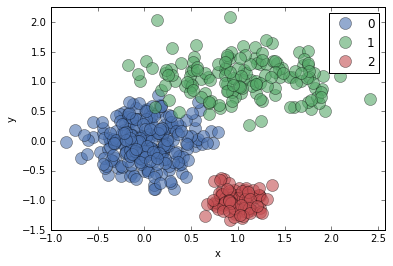

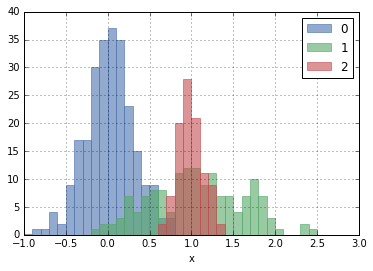

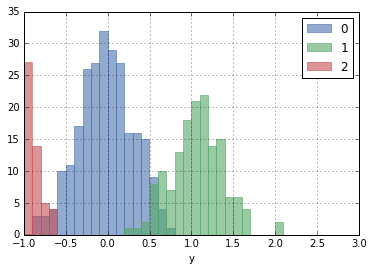

In [6]:
#______________________________________________________________________________
def scatter_plot(df, x, y):
    df_groupby = df.groupby('label')
    colors = pd.tools.plotting._get_standard_colors(len(df_groupby), color_type='default')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for i_grp, group in enumerate(df_groupby):
        label, df_group = group
        ax.plot(df_group[x], df_group[y], marker='o', linestyle='', ms=12, label=label, color=colors[i_grp], alpha=0.6)
    plt.xlabel(x)
    plt.ylabel(y)
    ax.legend(numpoints=1, loc='upper right')
    plt.show()
    return fig, ax

#______________________________________________________________________________
def histogram(df, var, by, bins=10):
    group_labels = df[by].unique()
    group_labels.sort()
    colors = pd.tools.plotting._get_standard_colors(len(group_labels), color_type='default')
    fig, ax = plt.subplots()
    for i_grp, label in enumerate(group_labels):
        df[df[by]==label][var].hist(bins=bins, label=str(label), color=colors[i_grp], edgecolor=colors[i_grp], alpha=0.6)
    plt.xlabel(var)
    ax.legend(loc='upper right')
    plt.show()
    return fig, ax

#==============================================
fig, ax = scatter_plot(df, x='x', y='y')
fig, ax = histogram(df, var='x', by='label', bins=np.arange(-1, 3, 0.1))
fig, ax = histogram(df, var='y', by='label', bins=np.arange(-1, 3, 0.1))

<a id="z_statistic"></a>

## $z$ statistic

A normalilzed random variable, $Z$, follows the normal (Gaussian) distribution.
A $z$ statistic can be calculated from any random variable $X$, where the population variance of $X$ is known to be $\sigma$, by

$z = \frac{{\bar{X}}-\mu}{{\sigma \: /\sqrt{n}}}$

For example, let's normalize the $x$ data from class 0:

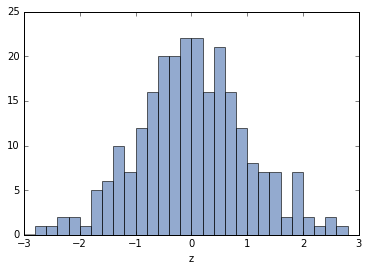

In [7]:
xdata0 = df[df['label']==0]['x']
zscores = stats.zscore(xdata0, ddof=1)
stuff = plt.hist(zscores, bins=np.arange(-3, 3, 0.2), alpha=0.6)
stuff1 = plt.xlabel('z')

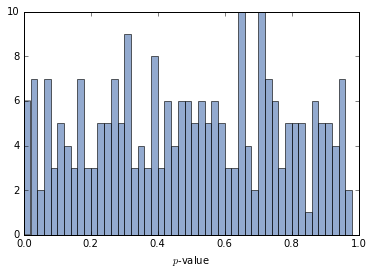

In [8]:
#p_values = stats.norm.sf(abs(zscores)) # one-sided
#p_values2 = stats.norm.sf(abs(zscores))*2 # twosided
p_values = stats.norm.sf(zscores)
stuff = plt.hist(p_values, bins=np.arange(0.0, 1.0, 0.02), alpha=0.6)
stuff1 = plt.xlabel('$p$-value')

**Following the *Data Science From Scratch*, p. 82-88**

Let's setup the normal cumulative distribution from scratch, as we will use this later in many ways when calculating $p$-values and limits.

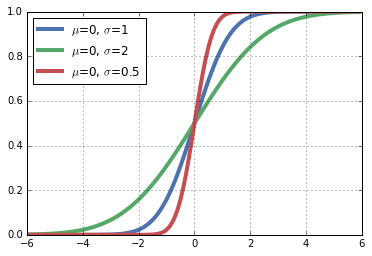

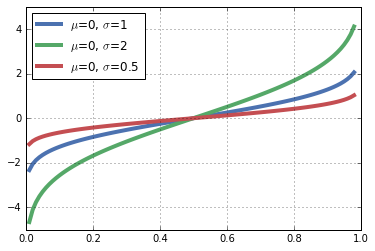

In [9]:
#______________________________________________________________________________
def normal_cdf(x, mu=0.0, sigma=1.0):
    return (1.0 + math.erf((x-mu) / (math.sqrt(2.0)*sigma))) / 2.0

#______________________________________________________________________________
def inverse_normal_cdf(p, mu=0.0, sigma=1.0, tolerance=0.00001):
    """
    Finds approximate inverse using binary search.
    From Data Science From Scratch, p. 78.
    """
    # if not standard, compute standard and rescale
    if mu != 0.0 or sigma != 1.0:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0.0          # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1.0          # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2.    # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z

#______________________________________________________________________________
def plot_normal_cdf(x=None, mu=0, sigma=1):
    if x is None:
        x = np.arange(-6.0, 6.0, 0.1)
    mu_1, sigma_1 = 0.0, 1.0
    mu_2, sigma_2 = 0.0, 2.0
    mu_3, sigma_3 = 0.0, 0.5
    y1 = [normal_cdf(x1, mu_1, sigma_1) for x1 in x ]
    y2 = [normal_cdf(x1, mu_2, sigma_2) for x1 in x ]
    y3 = [normal_cdf(x1, mu_3, sigma_3) for x1 in x ]
    colors = pd.tools.plotting._get_standard_colors(5, color_type='default')
    fig, ax = plt.subplots()
    ax.plot(x, y1, color=colors[0], linewidth=4, label='$\mu$=%.3g, $\sigma$=%.3g' % (mu_1, sigma_1))
    ax.plot(x, y2, color=colors[1], linewidth=4, label='$\mu$=%.3g, $\sigma$=%.3g' % (mu_2, sigma_2))
    ax.plot(x, y3, color=colors[2], linewidth=4, label='$\mu$=%.3g, $\sigma$=%.3g' % (mu_3, sigma_3))
    ax.legend(loc='upper left')
    ax.grid()
    plt.show()
    
#______________________________________________________________________________
def plot_inverse_normal_cdf(x=None, mu=0, sigma=1):
    if x is None:
        x = np.arange(0.01, 0.99, 0.01)
    mu_1, sigma_1 = 0.0, 1.0
    mu_2, sigma_2 = 0.0, 2.0
    mu_3, sigma_3 = 0.0, 0.5
    y1 = [inverse_normal_cdf(x1, mu_1, sigma_1) for x1 in x ]
    y2 = [inverse_normal_cdf(x1, mu_2, sigma_2) for x1 in x ]
    y3 = [inverse_normal_cdf(x1, mu_3, sigma_3) for x1 in x ]
    colors = pd.tools.plotting._get_standard_colors(5, color_type='default')
    fig, ax = plt.subplots()
    ax.plot(x, y1, color=colors[0], linewidth=4, label='$\mu$=%.3g, $\sigma$=%.3g' % (mu_1, sigma_1))
    ax.plot(x, y2, color=colors[1], linewidth=4, label='$\mu$=%.3g, $\sigma$=%.3g' % (mu_2, sigma_2))
    ax.plot(x, y3, color=colors[2], linewidth=4, label='$\mu$=%.3g, $\sigma$=%.3g' % (mu_3, sigma_3))
    ax.legend(loc='upper left')
    ax.grid()
    plt.show()
    
#======================================
plot_normal_cdf()
plot_inverse_normal_cdf()

In [10]:
normal_prob_below = normal_cdf
#______________________________________________________________________________
def normal_prob_above(lo, mu=0.0, sigma=1.0):
    return 1.0 - normal_cdf(lo, mu, sigma)

def normal_prob_between(lo, hi, mu=0.0, sigma=1.0):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

def normal_prob_outside(lo, hi, mu=0.0, sigma=1.0):
    return 1.0 - normal_prob_between(lo, hi, mu, sigma)

def normal_upper_bound(p, mu=0.0, sigma=1.0):
    return inverse_normal_cdf(p, mu, sigma)

def normal_lower_bound(p, mu=0.0, sigma=1.0):
    return inverse_normal_cdf(1.0-p, mu, sigma)

def normal_two_sided_bounds(p, mu=0.0, sigma=1.0):
    tail_prob = (1 - p)/2.0
    upper_bound = normal_lower_bound(tail_prob, mu, sigma)
    lower_bound = normal_upper_bound(tail_prob, mu, sigma)
    return lower_bound, upper_bound

<a id="normal_approximation_to_the_binomial"></a>

## Normal approximation to the binomial

Note that the true binomial distribution is discrete, but as $n$ increases,
it can be approximated with the normal (Gaussian) distribution.

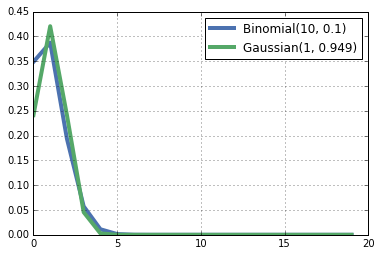

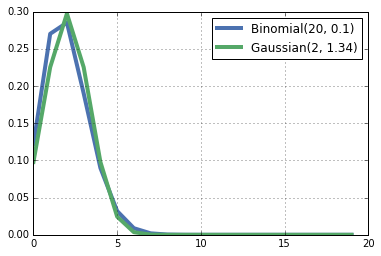

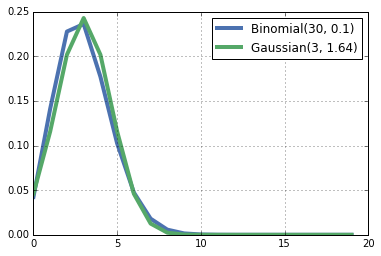

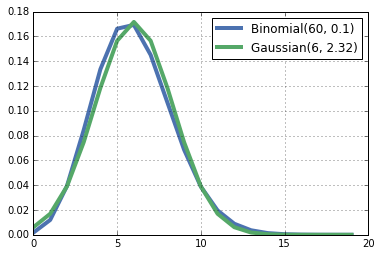

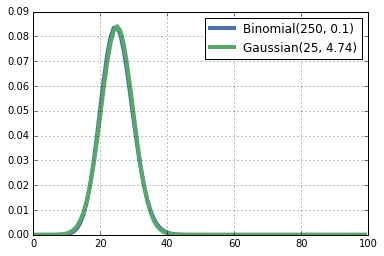

In [11]:
#______________________________________________________________________________
def normal_approximation_to_binomial(n, p):
    """
    Returns mu and sigma corresponding to Binomial(n, p)
    """
    mu = float(p*n)
    sigma = math.sqrt(p*(1.0-p)*n)
    return mu, sigma


#______________________________________________________________________________
def plot_normal_approximation(n, p, x=None):
    if x is None:
        x = np.arange(0.0, 20.0, 1.0)
    mu, sigma = normal_approximation_to_binomial(n, p)
    y1 = [ stats.binom.pmf(x1, n, p) for x1 in x ]
    y2 = [ stats.multivariate_normal.pdf(x1, mean=mu, cov=sigma*sigma) for x1 in x ]
    colors = pd.tools.plotting._get_standard_colors(5, color_type='default')
    fig, ax = plt.subplots()
    ax.plot(x, y1, color=colors[0], linewidth=4, label='Binomial(%i, %.3g)' % (n,p))
    ax.plot(x, y2, color=colors[1], linewidth=4, label='Gaussian(%i, %.3g)' % (mu,sigma))
    ax.legend(loc='upper right')
    #ax.set(xlabel='time (s)', ylabel='voltage (mV)',
    #       title='About as simple as it gets, folks')
    ax.grid()
    plt.show()
    

#=======================================
plot_normal_approximation(n=10, p=0.1, x=np.arange(0.0, 20.0, 1.0))
plot_normal_approximation(n=20, p=0.1, x=np.arange(0.0, 20.0, 1.0))
plot_normal_approximation(n=30, p=0.1, x=np.arange(0.0, 20.0, 1.0))
plot_normal_approximation(n=60, p=0.1, x=np.arange(0.0, 20.0, 1.0))
plot_normal_approximation(n=250, p=0.1, x=np.arange(0.0, 100.0, 1.0))

In [12]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print 'mu_0 = %.3g, sigma_0 = %.3g' % (mu_0, sigma_0)

mu_0 = 500, sigma_0 = 15.8


In [13]:
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print 'lo = %.3g, hi = %.3g' % (lo, hi)

lo = 469, hi = 531


In [14]:
#______________________________________________________________________________
def two_sided_p_value(x, mu=0.0, sigma=1.0):
    x0 = abs(x - mu)
    p = 2.0 * normal_prob_above(x0, 0.0, sigma)
    return p

upper_limit_p_value = normal_prob_above
lower_limit_p_value = normal_prob_below

In [15]:
p = two_sided_p_value(529.5, mu_0, sigma_0)
print 'p = %.5g' % (p)

p = 0.062077


In [16]:
p = upper_limit_p_value(524.5, mu_0, sigma_0)
print 'p = %.5g' % (p)

p = 0.060629


TODO: Note that [Yates's correction](https://en.wikipedia.org/wiki/Yates%27s_correction_for_continuity) is being used above when using 525 - 0.5 = 524.5.

<a id="t_statistic"></a>

## $t$ statistic

The [$t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test) is a statistical hypothesis test can be used to determine if sets of data are significantly different from each other.  A $t$-test is most commonly used when the test statistic, $t$, would follow a normal distribution if the value of a scaling term were known. When the scaling term is unknown and is replaced by an estimate based on the data, the test statistic (under certain conditions) follows a [Student's $t$ distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).

$t={\frac {Z}{s}}={\frac {\left({\bar {X}}-\mu \right)\left/\left({\frac {\sigma }{\sqrt {n}}}\right)\right.}{s}}$

TODO:

-   used when variance is unknown

First, let's do a 1-sample t-test with the data of one variable from one class (`label=0`).

In [17]:
result = stats.ttest_1samp(xdata0, 0.0)
t = result.statistic
p = result.pvalue
print 't = %.5g' % (t)
print 'p = %.5g' % (p)

t = 1.2193
p = 0.22389


A $p$-value of 22%, doesn't indicate a significant discrepancy in the single sample.

A $t$-statistic is often used to test a null hypothesis about two means; most often, it tests the hypothesis that two means are equal, or that the difference between them is zero.  In this case, [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) is used. In Welch's t-test, there are two different data samples which in general have different, unknown variances.

$t = {\;\overline {X}_{1}-\overline {X}_{2}\; \over {\sqrt  {\;{s_{1}^{2} \over N_{1}}\;+\;{s_{2}^{2} \over N_{2}}\quad }}}\,$

Now, let's normalize the $x$ data from classes 1 and 2, and use a Welch $t$-test to test if the means of the classes are signficantly different.

Class 0 and 1 have significantly different means for $x$, $p$-value $\approx 10^{-82}$:

In [18]:
xdata1 = df[df['label']==1]['x']
result = stats.ttest_ind(xdata0, xdata1)
t = result.statistic
p = result.pvalue
print 't = %.5g' % (t)
print 'p = %.5g' % (p)

t = -24.82
p = 7.5819e-83


Class 1 and 2 do *not* have significantly different means for $x$, $p$-value = 16%:

In [19]:
xdata2 = df[df['label']==2]['x']
result = stats.ttest_ind(xdata1, xdata2)
t = result.statistic
p = result.pvalue
print 't = %.5g' % (t)
print 'p = %.5g' % (p)

t = 1.4067
p = 0.16076


For [example](http://www.theseashore.org.uk/theseashore/Stats%20for%20twits/T%20Test.html), we could test whether men and women have the same average weight.

Let's say we have series of measurements of weight in kg and sex (0=male, 1=female):

TODO

Abstractly, a $t$ statistic with $k$ degrees of freedom can be constructed by dividing a normally distributed random variable by an independent $\chi^{2}_{k}$ distribution:

$t_k = \frac{Z_0}{\sqrt{\left(\sum_i^k Z_i^2\right) / k}} \sim \frac{N(0, 1)}{\sqrt{\chi^{2}_{k} / k}}$

For more details, see [Allwood (2008)](https://secure-media.collegeboard.org/apc/ap05_stats_allwood_fin4prod.pdf).

<a id="chi2_statistic"></a>

## $\chi^2$ statistic

Unlike $z$ and $t$ tests, $\chi^2$ uses categorical/binned data.

Often we are interested in measuring some rate of interest, $\rho \in [0, 1]$, that can be thought of as a success rate or conversion rate: the fraction of events that did something of interest.  In the framework of A/B-testing, not only do we want to measure a parameter of interest, but we want to see if it is *significantly* different between two samples: $A$ and $B$. Often sample $A$ is thought of as the original or control version, and in sample $B$, we have made some kind of systematic change, and we want to test if that *significantly* changes $\rho$.

**Following the blitzresults.com example**

Working out the example [here](http://www.blitzresults.com/en/ab-tests/) with the $\chi^2$ method.

In [20]:
##=============================================================================
## USER INPUT
##=============================================================================
N_A1 =  960.  # not converted, sample A
N_A2 =   40.  # converted, sample A
N_B1 = 1120.  # not converted, sample B
N_B2 =   80.  # converted, sample B

First, let's calculate the conversion rate from the total number of events and conversions.

In [21]:
#______________________________________________________________________________
def a_b_test_conversion_rate(N_A1, N_A2, N_B1, N_B2):
    N_1 = N_A1 + N_B1
    N_2 = N_A2 + N_B2
    rho = N_2/(N_1+N_2)
    return rho

rho = a_b_test_conversion_rate(N_A1, N_A2, N_B1, N_B2)
print 'Conversion rate, rho = %.5g' % (rho)

Conversion rate, rho = 0.054545


In general, when calculating $\chi^2$ for comparing the goodness of fit of a model to the observed data:

$\chi^2 = \sum_{i} \frac{(O_i - E_i)^2}{E_i}$

Assuming the conversion rate is the same among samples $A$ and $B$,

$\chi^2 = \frac{(N_{A1} - N_{A}*(1-\rho))^2}{N_{A}*(1-\rho)} + \frac{(N_{A2} - N_{A}*\rho)^2}{N_{A}*\rho} + \frac{(N_{B1} - N_{B}*(1-\rho))^2}{N_{B}*(1-\rho)} + \frac{(N_{B2} - N_{B}*\rho)^2}{N_{B}*\rho}$

In [22]:
#______________________________________________________________________________
def a_b_test_chi2(N_A1, N_A2, N_B1, N_B2):
    N_A = N_A1 + N_A2
    N_B = N_B1 + N_B2
    N_1 = N_A1 + N_B1
    N_2 = N_A2 + N_B2
    rho = N_2/(N_1+N_2)
    chi2 = ((N_A1 - N_A*(1-rho))**2)/(N_A*(1-rho)) + \
           ((N_A2 - N_A*rho)**2)/(N_A*rho) + \
           ((N_B1 - N_B*(1-rho))**2)/(N_B*(1-rho)) + \
           ((N_B2 - N_B*rho)**2)/(N_B*rho)
    ## checking the chi2 term-by-term:
    #print '%.5g' % (((N_A1 - N_A*(1-rho))**2)/(N_A*(1-rho)))
    #print '%.5g' % (((N_A2 - N_A*rho)**2)/(N_A*rho))
    #print '%.5g' % (((N_B1 - N_B*(1-rho))**2)/(N_B*(1-rho)))
    #print '%.5g' % (((N_B2 - N_B*rho)**2)/(N_B*rho))
    return chi2
        
chi2 = a_b_test_chi2(N_A1, N_A2, N_B1, N_B2)
print 'chi2 = %.5g' % (chi2)

chi2 = 7.5214


Comparing this $\chi^2$ value with a [table of critical values](https://home.ubalt.edu/ntsbarsh/Business-stat/StatistialTables.pdf), with degrees of freedom = 1,
shows that the corresponding $p$-value for $\chi^2$ = 7.52 to be smaller than 1%, which corresponds to $\chi^2$ = 6.635.  Note that degrees of freedom is 1 because there is only one free parameter in the model: $\rho$.

![](media/critical-values-of-chi2.png)

Instead of looking up the $p$-value in a table, we can also calculate it with `scipy.stats`:

In [23]:
obs = [[N_A1, N_A2], [N_B1, N_B2]]
chi2, p, dof, ex = stats.chi2_contingency(obs, correction=False)
print 'chi2 = %.5g' % (chi2)
print 'p    = %.5g' % (p)
print 'dof  = %.5g' % (dof)
print 'expected = %s' % (ex)

chi2 = 7.5214
p    = 0.0060971
dof  = 1
expected = [[  945.45454545    54.54545455]
 [ 1134.54545455    65.45454545]]


So the $p$-value is 0.6%, rather significant.

Above, `correction=False` means that we do not do the [Yates's correction](https://en.wikipedia.org/wiki/Yates%27s_correction_for_continuity).

**Following the elegantthemes.com example**

Working out another example [here](https://www.elegantthemes.com/blog/resources/how-to-determine-statistical-significance-when-ab-testing-with-divi-leads) with the $\chi^2$ method.

In [24]:
##=============================================================================
## USER INPUT
##=============================================================================
N_A1 = 976.  # not converted, sample A
N_A2 =  43.  # converted, sample A
N_B1 = 992.  # not converted, sample B
N_B2 =  34.  # converted, sample B

In [25]:
obs = [[N_A1, N_A2], [N_B1, N_B2]]
chi2, p, dof, ex = stats.chi2_contingency(obs, correction=False)
print 'chi2 = %.5g' % (chi2)
print 'p    = %.5g' % (p)
print 'dof  = %.5g' % (dof)
print 'expected = %s' % (ex)

chi2 = 1.1581
p    = 0.28186
dof  = 1
expected = [[ 980.63178484   38.36821516]
 [ 987.36821516   38.63178484]]


Having a $p$-value of 28%, I wouldn't say there is a significant difference in samples $A$ and $B$.

**Following the *Data Science From Scratch*, p. 88**

*Data Science From Scratch* defines the equivalent of

$z = (p_B - p_A) / \sqrt{\sigma_{p_A}^2 + \sigma_{p_B}^2}$

and uses the `normal_approximation_to_binomial` to calculate gaussian errors for $p_A$ and $p_B$.

In [26]:
#______________________________________________________________________________
def a_b_test_statistic(N_A1, N_A2, N_B1, N_B2):
    """
    A/B-test statistic from Data Science From Scratch, p. 88 (modified by Ryan).
    Compare this with the chi2 method implemented below: a_b_test_chi2(...)
    """
    N_A = float(N_A1 + N_A2)
    p_A = N_A2 / N_A if N_A2 else 0.01
    mu_A, sigma_A = normal_approximation_to_binomial(N_A, p_A)
    N_B = float(N_B1 + N_B2)
    p_B = N_B2 / N_B if N_B2 else 0.01
    mu_B, sigma_B = normal_approximation_to_binomial(N_B, p_B)
    sigma_pA = sigma_A/N_A if N_A else 0.01
    sigma_pB = sigma_B/N_B if N_B else 0.01
    z = (p_B - p_A) / math.sqrt(sigma_pA**2 + sigma_pB**2)
    return z

In [27]:
z = a_b_test_statistic(800, 200, 820, 180)
print 'z = %.3g' % (z)

z = -1.14


In [28]:
p = two_sided_p_value(z)
print 'p = %.5g' % (p)

p = 0.25414


Now let's check if `a_b_test_statistic` from *Data Science From Scratch* gives a result similar to what we worked out above from the blitzresults.com example.

In [29]:
N_A1 =  960.  # not converted, sample A
N_A2 =   40.  # converted, sample A
N_B1 = 1120.  # not converted, sample B
N_B2 =   80.  # converted, sample B

z = a_b_test_statistic(N_A1, N_A2, N_B1, N_B2)
print 'z = %.3g' % (z)

z = 2.81


In [30]:
p = two_sided_p_value(z)
print 'p = %.5g' % (p)

p = 0.0050007


Notice that 0.5% is indeed close to our previous result of 0.6%

Now let's check `a_b_test_statistic` on the elegantthemes.com example.

In [31]:
N_A1 =  976.  # not converted, sample A
N_A2 =   43.  # converted, sample A
N_B1 =  992.  # not converted, sample B
N_B2 =   34.  # converted, sample B

z = a_b_test_statistic(N_A1, N_A2, N_B1, N_B2)
print 'z = %.3g' % (z)

z = -1.08


In [32]:
p = two_sided_p_value(z)
print 'p = %.5g' % (p)

p = 0.28192


Again, a $p$-value of 28% is consistent with the $\chi^2$ method we used above.

TODO: compare with [scipy.stats.binom_test](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.binom_test.html)

<a id="see_also"></a>

## See also

References:

-   [Wikipedia: Confidence interval](https://en.wikipedia.org/wiki/Confidence_interval)
-   [Wikipedia: Lady tasting tea](https://en.wikipedia.org/wiki/Lady_tasting_tea)
-   [Wikipedia: Binomial proportion confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)
-   [Wikipedia: Binomial test](https://en.wikipedia.org/wiki/Binomial_test)
-   [Wikipedia: Rule of three](https://en.wikipedia.org/wiki/Rule_of_three_%28statistics%29)
-   [Wikipedia: Student's $t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test)
-   [Wikipedia: Welch's $t$-test](https://en.wikipedia.org/wiki/Welch%27s_t-test)
-   [Wikipedia: Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test)
-   [Tables of critical values](https://home.ubalt.edu/ntsbarsh/Business-stat/StatistialTables.pdf)
-   [Statistics for Dummies Cheat Sheet](http://www.dummies.com/education/math/statistics/statistics-for-dummies-cheat-sheet/)
-   [Leemis & McQueston (2008). Univariate Distribution Relationships.](http://www.stat.rice.edu/~dobelman/courses/texts/leemis.distributions.2008amstat.pdf)

Illuminating discussions:

-   [KhanAcademy: hypothesis testing videos](https://www.khanacademy.org/math/statistics-probability/significance-tests-one-sample/more-significance-testing-videos/v/large-sample-proportion-hypothesis-testing)
-   [Quora: What is an intuitive explanation for how the $t$, $z$, and $\chi^2$-distributions are related?](https://www.quora.com/What-is-an-intuitive-explanation-for-how-the-t-distribution-normal-distribution-F-distribution-and-Chi-square-distribution-relate-to-each-other-Why-do-all-these-different-distributions-exist-and-when-do-we-use-each-in-statistical-testing/answer/Chandrima-Das)
-   [Quora: How can I do an A/B test in Python?](https://www.quora.com/How-can-I-do-an-A-B-test-in-Python)
-   [Allwood, M. (2008). The Satterthwaite Formula for degrees of freedom in the two-sample $t$-test.](https://secure-media.collegeboard.org/apc/ap05_stats_allwood_fin4prod.pdf)
-   [A/B Testing Statistics: An intuitive guide for non-mathematicians](https://conversionsciences.com/blog/ab-testing-statistics/)

Some worked examples:

-   [hypothesis_and_inference.py from *Data Science From Scratch*](https://github.com/joelgrus/data-science-from-scratch/blob/master/code/hypothesis_and_inference.py)
-   [Stats notes at The Seashore](http://www.theseashore.org.uk/theseashore/Stats%20for%20twits/T%20Test.html)
-   [$\chi^2$-test for A/B-tests at blitzresults.com](http://www.blitzresults.com/en/ab-tests)
-   [$\chi^2$-test for A/B-tests at elegantthemes.com](https://www.elegantthemes.com/blog/resources/how-to-determine-statistical-significance-when-ab-testing-with-divi-leads)
-   [$\chi^2$-test for independence (biology example)](https://www.biologyforlife.com/x2-test-for-independence.html)
-   [2-sample $t$-test for A/B-tests in R](https://rexplorations.wordpress.com/2015/08/13/hypothesis-tests-2-sample-tests-ab-tests/)
-   [A/B Testing with Hierarchical Models in Python (Bayesian)](https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/)

Toolkits:

-   [scipy.stats](https://docs.scipy.org/doc/scipy-0.18.0/reference/stats.html)
    -   [scipy.stats.binom_test](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.binom_test.html)
    -   [scipy.stats.ttest_1samp](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.ttest_1samp.html#scipy.stats.ttest_1samp)
    -   [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)
    -   [scipy.stats.zscore](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.zscore.html#scipy.stats.zscore)
    
More pedagogy:

-    [Cranmer, K. (2015). Practical Statistics for the LHC.](https://arxiv.org/abs/1503.07622)
-    [Cowan, G. (2015). Review of Particle Physics (PDG): Statistics.](http://pdg.lbl.gov/2015/reviews/rpp2015-rev-statistics.pdf)

Maybes:

-   [are-different-p-values-for-chi-squared-and-z-test-expected](https://stats.stackexchange.com/questions/141547/are-different-p-values-for-chi-squared-and-z-test-expected-for-testing-differenc)
-   [a-b-tests-z-test-vs-t-test-vs-chi-square-vs-fisher-exact-test](https://stats.stackexchange.com/questions/178854/a-b-tests-z-test-vs-t-test-vs-chi-square-vs-fisher-exact-test)
-   [difference-between-ttest-chi-square](https://sciencing.com/difference-between-ttest-chi-square-8225095.html)



## Taken from Mark

In [33]:
#from statsmodels.stats.proportion import proportions_ztest
#
#count = np.array([4031, 1777])
#nobs = np.array([202672, 114128])
#proportions_ztest(count,nobs,value=None, alternative='two-sided')
## stat, pval =proportions_ztest(count, nobs, value)
## print('%.80f' % pval)

In [34]:
#import statsmodels.stats.api as sms
#es = sms.proportion_effectsize(0.019889, 0.015570)
#sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)